In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')

X = df.drop(['id','NObeyesdad'], axis=1)
y = df['NObeyesdad']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=55)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Used models: Logistic Regression, LDA, Naïve Bayes, and SVM.  
## Multinomial Logistic Regression  

Logistic Regression Accuracy: 0.870


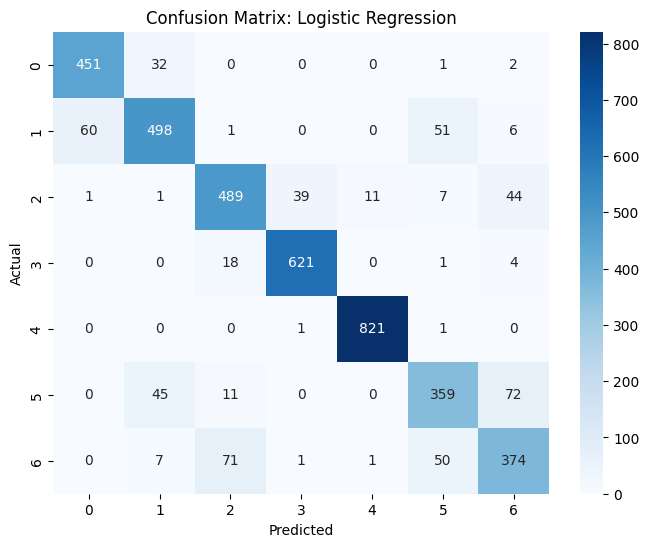

In [3]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
logreg.fit(X_train_processed, y_train)
y_pred_logreg = logreg.predict(X_test_processed)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logreg):.3f}")
plot_conf_matrix(y_test, y_pred_logreg, title="Logistic Regression")

Multinomial Logistic Regression Assumptions:  
    Linearity between predictors and the log-odds.  
    No or low multicollinearity.  
    Independence of observations.

VIF Scores:
          VIF
12  24.130787
16  20.830654
10  11.657115
20   9.494448
17   7.821893


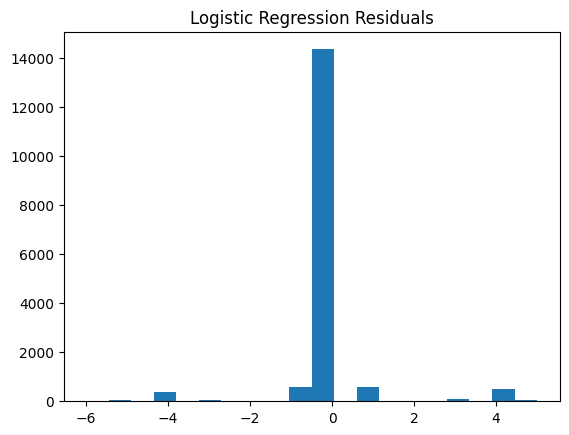

In [4]:
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(X_train_processed, i) for i in range(X_train_processed.shape[1])]
print("VIF Scores:")
print(vif_data.sort_values("VIF", ascending=False).head())

residuals = y_train - logreg.predict(X_train_processed)
plt.hist(residuals, bins=20)
plt.title("Logistic Regression Residuals")
plt.show()

Logistic Regression has a good accuracy (87%) but assumptions are not satisfied. 

## Linear Discriminant Analysis

LDA Accuracy: 0.821


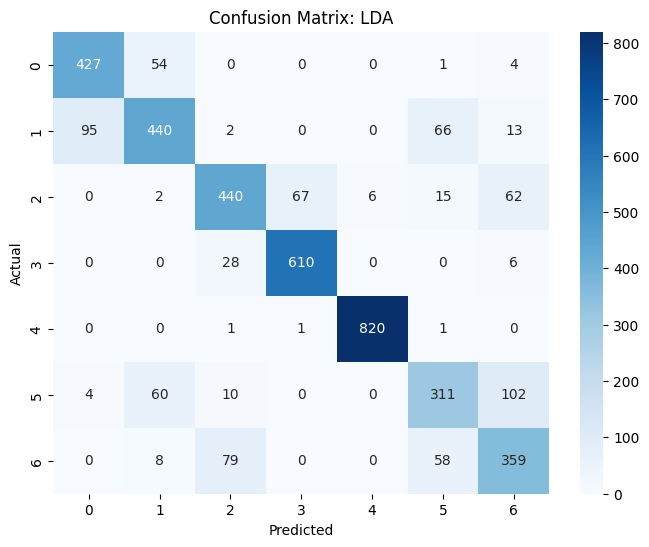

In [5]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_processed, y_train)
y_pred_lda = lda.predict(X_test_processed)
print(f"LDA Accuracy: {accuracy_score(y_test, y_pred_lda):.3f}")
plot_conf_matrix(y_test, y_pred_lda, title="LDA")

LDA Assumptions:  
Equal class covariances similarity.  
Multivariate Q-Q plots for normality.

Mean variance between class covariances: 2.2989164522837737


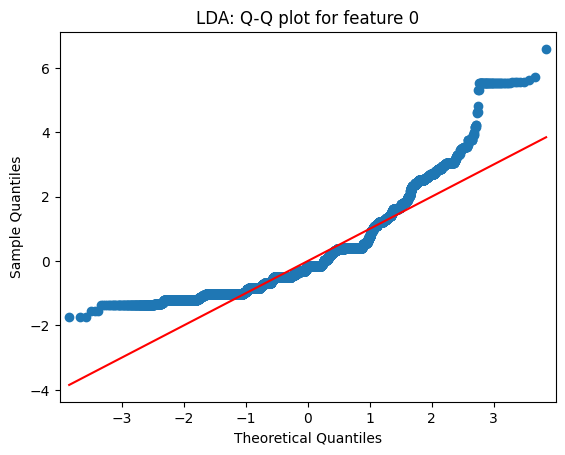

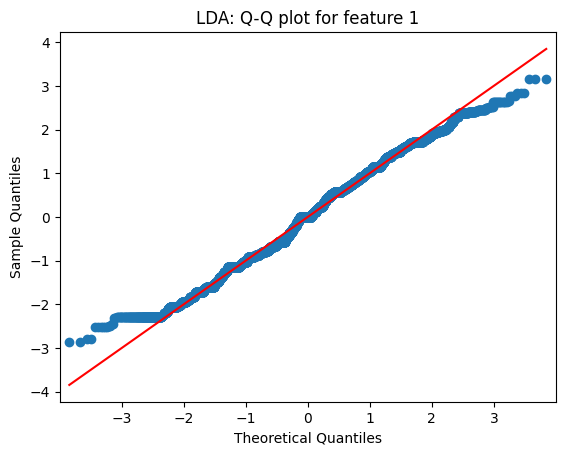

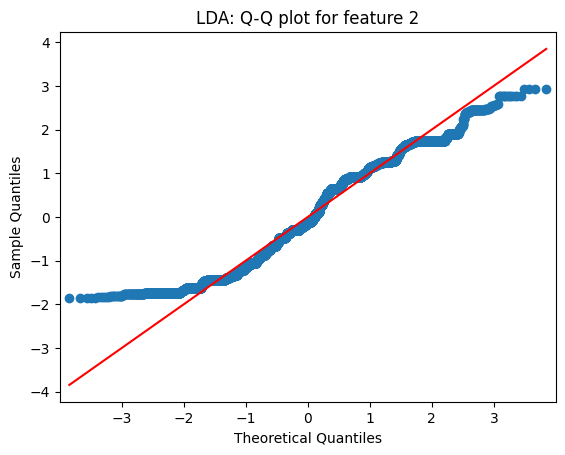

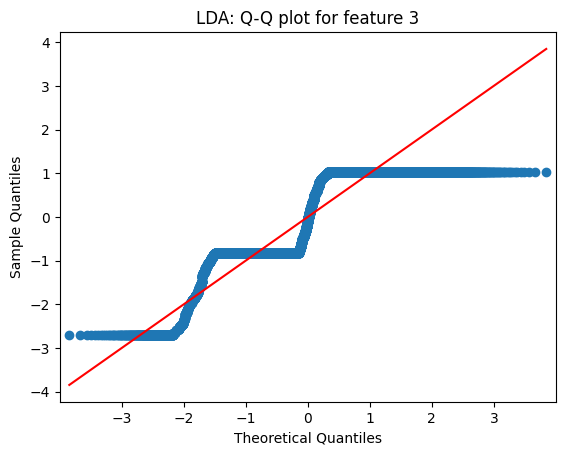

In [6]:
cov_matrices = [np.cov(X_train_processed[y_train == i].T) for i in np.unique(y_train)]
diffs = [np.linalg.norm(cov_matrices[i] - cov_matrices[j]) for i in range(len(cov_matrices)) for j in range(i+1, len(cov_matrices))]
print("Mean variance between class covariances:", np.mean(diffs))

#for i in range(X_train_processed.shape[1]):
for i in range(4): #plotting first 4 features
    sm.qqplot(X_train_processed[:, i], line='s')
    plt.title(f'LDA: Q-Q plot for feature {i}')
    plt.show()

LDA accuracy is 82%.  
Distributions are not normal.  
Mean variance between class covariances is small, so covariance similarity holds between few variables but not all variables.  
## Naïve Bayes

Naïve Baye Accuracy: 0.604


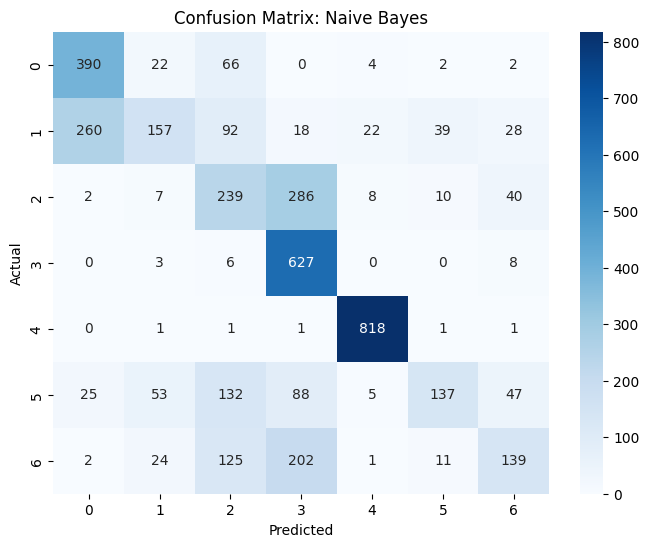

In [7]:
nb = GaussianNB()
nb.fit(X_train_processed, y_train)
y_pred_naive = nb.predict(X_test_processed)
print(f"Naïve Baye Accuracy: {accuracy_score(y_test, y_pred_naive):.3f}")
plot_conf_matrix(y_test, y_pred_naive, title="Naive Bayes")

Assumptions:  
Feature independence via correlation heatmap

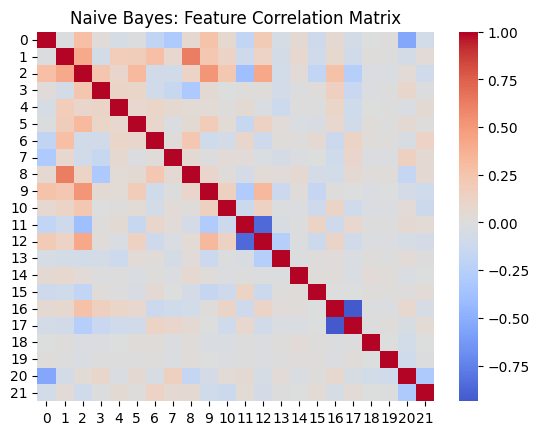

In [8]:
sns.heatmap(pd.DataFrame(X_train_processed).corr(), cmap='coolwarm', center=0)
plt.title("Naive Bayes: Feature Correlation Matrix")
plt.show()

Naïve Bayes accuracy is 60.4%.  
Most features are independent.  
## Support Vector Machine (SVM).

SVM Accuracy: 0.877


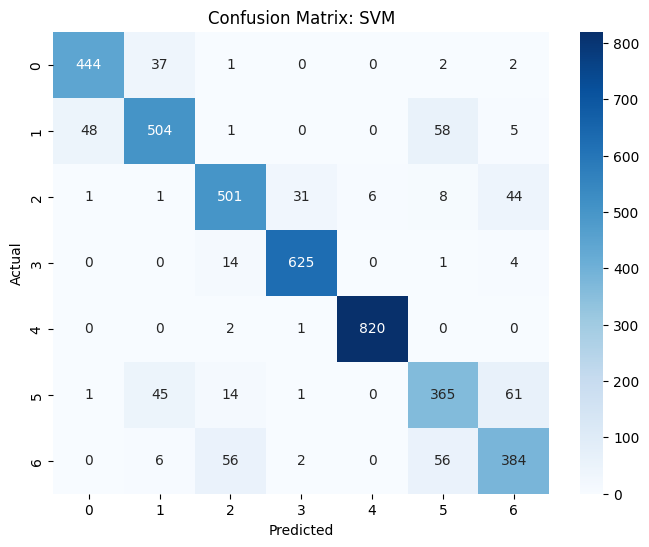

In [9]:
svm = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')
svm.fit(X_train_processed, y_train)
y_pred_svm = svm.predict(X_test_processed)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")
plot_conf_matrix(y_test, y_pred_svm, title="SVM")

SVM does not assume linearity or normality. Data should be scaled.  
SVM shows highest accuracy (87.7%)  

In [10]:
models = {
    'Logistic Regression': y_pred_logreg,
    'LDA': y_pred_lda,
    'Naive Bayes': y_pred_naive,
    'SVM': y_pred_svm
}

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    print(f'{name} Accuracy: {acc:.3f}')

Logistic Regression Accuracy: 0.870
LDA Accuracy: 0.821
Naive Bayes Accuracy: 0.604
SVM Accuracy: 0.877


Results show SVM performed well, most likely because it does not rely on distribution assumptions.

In [11]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
test_ids = test_df["id"]
test_df_X = test_df.drop('id', axis=1)
X_test_proc = preprocessor.transform(test_df_X)

y_logreg_preds = logreg.predict(X_test_proc)
y_lda_preds = lda.predict(X_test_proc)
y_naive_preds = nb.predict(X_test_proc)
y_svm_preds = svm.predict(X_test_proc)
y_logreg_preds = np.maximum(0, y_logreg_preds)
y_lda_preds = np.maximum(0, y_lda_preds)
y_naive_preds = np.maximum(0, y_naive_preds)
y_svm_preds = np.maximum(0, y_svm_preds)

# --- Save submission files ---
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_logreg_preds})
submission.to_csv("submission_logreg.csv", index=False)
print("Submissions logreg saved: submission_logreg.csv")
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_lda_preds})
submission.to_csv("submission_lda.csv", index=False)
print("Submissions logreg saved: submission_lda.csv")
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_naive_preds})
submission.to_csv("submission_nb.csv", index=False)
print("Submissions logreg saved: submission_nb.csv")
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_svm_preds})
submission.to_csv("submission_svm.csv", index=False)
print("Submissions logreg saved: submission_svm.csv")

Submissions logreg saved: submission_logreg.csv
Submissions logreg saved: submission_lda.csv
Submissions logreg saved: submission_nb.csv
Submissions logreg saved: submission_svm.csv
